<a href="https://colab.research.google.com/github/realxoman/PoultryInspector/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [50]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# مسیر دیتاست
train_val_dir = "/content/drive/MyDrive/Poultry/train"  # مسیر به دایرکتوری training و validation
test_dir = "/content/drive/MyDrive/PoultryInspector/test"  # مسیر به دایرکتوری test

# تعریف ترنسفورم‌ها (پیش‌پردازش‌ها و augmentation)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(30),  # افزایش چرخش
        transforms.Resize((299, 299)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # تغییر رنگی قوی‌تر
        transforms.ToTensor(),  # تبدیل تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
        # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.GaussianBlur(3),
        # transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Cutout
    ]),
    "validation": transforms.Compose([
         transforms.RandomRotation(30),  # افزایش چرخش
        transforms.Resize((299, 299)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # تغییر رنگی قوی‌تر
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# تغییر پسوند فایل‌ها به حروف کوچک
def lower_case_extension(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower() != file:  # اگر پسوند فایل به حروف کوچک نیست
                os.rename(os.path.join(root, file), os.path.join(root, file.lower()))  # تغییر به حروف کوچک
    return path

# بارگذاری داده‌های آموزش و اعتبارسنجی از یک دایرکتوری (train_val_dir)
train_val_dir = lower_case_extension(train_val_dir)
test_dir = lower_case_extension(test_dir)

train_val_dataset = datasets.ImageFolder(root=train_val_dir, transform=data_transforms['train'])

# تقسیم‌بندی داده‌ها به آموزش و اعتبارسنجی (80% آموزش، 20% اعتبارسنجی)
train_size = int(0.7 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# اعمال ترنسفورم‌های مناسب به هر بخش
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['validation']

# بارگذاری داده‌های تست از دایرکتوری جداگانه (test_dir)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])

from torch.utils.data import WeightedRandomSampler

class_counts = [30, 17]  # تعداد نمونه‌های هر کلاس
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=2, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader,
}

# تعداد نمونه‌ها در هر بخش
dataset_sizes = {'train': len(train_dataset), 'validation': len(val_dataset), 'test': len(test_dataset)}

# نام کلاس‌ها (دسته‌ها)
class_names = train_val_dataset.classes

print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

num_aug_per_epoch = len(dataloaders["train"])  # تعداد batchها در هر epoch
effective_dataset_size = 2 * dataset_sizes['train']  # تعداد تصاویر "مجازی" در هر epoch (32 = batch size)

print(f"Effective Train size (with augmentation per epoch): {effective_dataset_size}")


Class names: ['defrost', 'fresh']
Dataset sizes: {'train': 236, 'validation': 102, 'test': 47}
Effective Train size (with augmentation per epoch): 472


In [32]:
# لیست‌ها برای ذخیره مقادیر
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

Epoch 1/50
----------
Train Loss: 1.4914 Acc: 0.7203
Validation Loss: 0.4825 Acc: 0.8529
Epoch 2/50
----------
Train Loss: 0.4127 Acc: 0.8305
Validation Loss: 0.2839 Acc: 0.8824
Epoch 3/50
----------
Train Loss: 0.2309 Acc: 0.9110
Validation Loss: 0.0563 Acc: 0.9902
Epoch 4/50
----------
Train Loss: 0.1979 Acc: 0.9322
Validation Loss: 0.0713 Acc: 1.0000
Epoch 5/50
----------
Train Loss: 0.0445 Acc: 0.9958
Validation Loss: 0.0202 Acc: 1.0000
Early Stopping Counter: 1/10
Epoch 6/50
----------
Train Loss: 0.0812 Acc: 0.9576
Validation Loss: 0.0366 Acc: 0.9902
Early Stopping Counter: 2/10
Epoch 7/50
----------
Train Loss: 0.1627 Acc: 0.9449
Validation Loss: 0.0375 Acc: 0.9902
Early Stopping Counter: 3/10
Epoch 8/50
----------
Train Loss: 0.0388 Acc: 0.9915
Validation Loss: 0.0449 Acc: 1.0000
Early Stopping Counter: 4/10
Epoch 9/50
----------
Train Loss: 0.0956 Acc: 0.9619
Validation Loss: 0.0156 Acc: 1.0000
Early Stopping Counter: 5/10
Epoch 10/50
----------
Train Loss: 0.0065 Acc: 1.0000


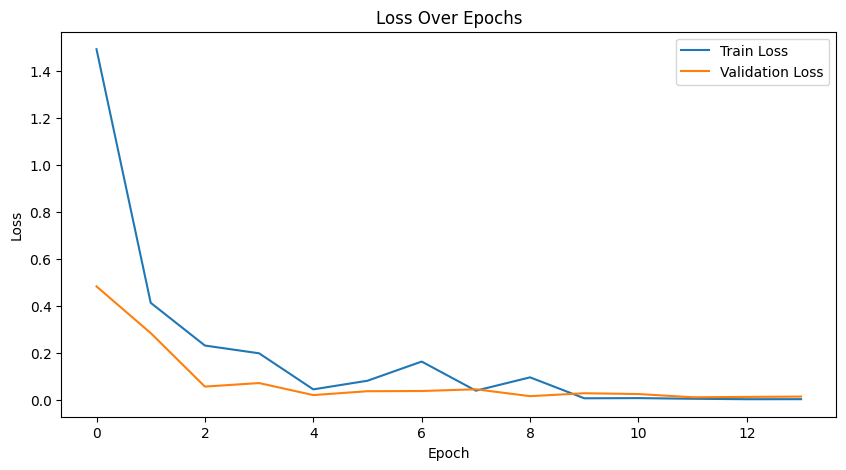

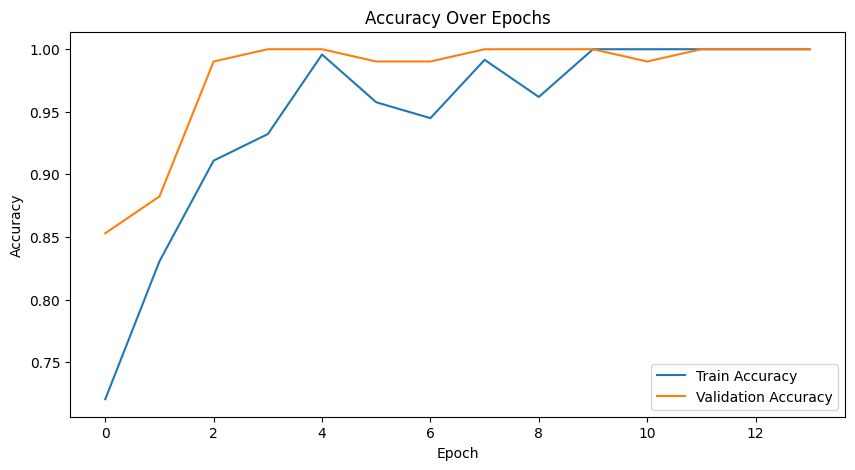

Classification Report:
               precision    recall  f1-score   support

     defrost       1.00      1.00      1.00        30
       fresh       1.00      1.00      1.00        17

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



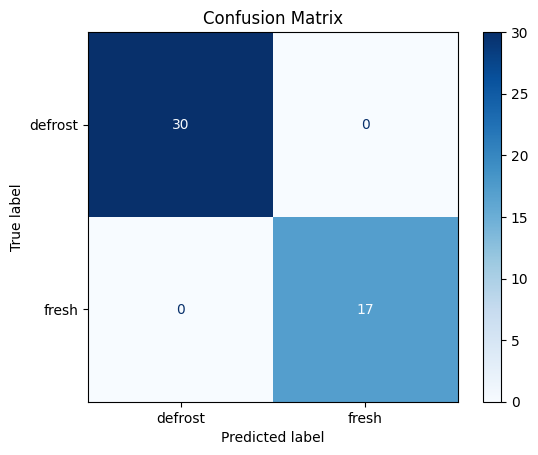

In [47]:
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# تعداد ویژگی‌های خروجی لایه Fully Connected
# num_ftrs = model.fc.in_features

# # تغییر لایه Fully Connected با اضافه کردن Dropout و Linear
# model.fc = nn.Sequential(
#     nn.Dropout(0.3),  # اضافه کردن Dropout با نرخ 0.3
#     nn.Linear(num_ftrs, len(class_names))  # تغییر تعداد خروجی‌ها به تعداد کلاس‌ها
# )


# model.classifier = nn.Sequential(
#     nn.Dropout(0.3),  # Dropout برای کاهش overfitting
#     nn.Linear(num_ftrs, len(class_names))
# )
# for param in model.features.parameters():
#     param.requires_grad = False


# num_ftrs = model.fc.in_features  # تعداد ویژگی‌های لایه Fully Connected
# model.fc = nn.Linear(num_ftrs, len(class_names))  # تغییر تعداد کلاس‌ها
# model = models.resnet50(weights=None)
# num_ftrs = model.last_channel  # تعداد ویژگی‌های لایه آخر
# model.classifier = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(num_ftrs, len(class_names))  # تغییر تعداد خروجی‌ها به تعداد کلاس‌ها
# )
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # انتقال مدل به GPU/CPU

# 2. تعریف loss function و optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)



def train_model_with_early_stopping(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=50, patience=10, save_path="best_model.pth"):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience_counter = 0  # شمارنده صبر برای Early Stopping

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):  # اگر خروجی tuple باشد (مثل Inception v3)
                        outputs = outputs[0]  # logits را بگیرید
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # Early Stopping Logic
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    patience_counter = 0  # ریست شمارنده صبر
                else:
                    patience_counter += 1
                    print(f"Early Stopping Counter: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("Early stopping triggered!")
                        model.load_state_dict(best_model_wts)
                        torch.save(model.state_dict(), save_path)  # ذخیره مدل
                        print(f"Model saved to {save_path}")

                         # رسم نمودار Loss
                        plt.figure(figsize=(10, 5))
                        plt.plot(train_losses, label='Train Loss')
                        plt.plot(val_losses, label='Validation Loss')
                        plt.title('Loss Over Epochs')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.legend()
                        plt.show()

                        # رسم نمودار Accuracy
                        plt.figure(figsize=(10, 5))
                        plt.plot(train_accuracies, label='Train Accuracy')
                        plt.plot(val_accuracies, label='Validation Accuracy')
                        plt.title('Accuracy Over Epochs')
                        plt.xlabel('Epoch')
                        plt.ylabel('Accuracy')
                        plt.legend()
                        plt.show()
                        return model, [train_losses, val_losses, train_accuracies, val_accuracies]


    print("Training complete. Best val Acc: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)  # ذخیره مدل
    print(f"Model saved to {save_path}")

    # رسم نمودار Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # رسم نمودار Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model , [train_losses, val_losses, train_accuracies, val_accuracies]

# آموزش مدل و رسم نمودارها
model, list_ac = train_model_with_early_stopping(
    model,
    criterion,
    optimizer,
    dataloaders,
    dataset_sizes,
    num_epochs=50,
    save_path="best_model_inception.pth"
)

train_losses, val_losses, train_accuracies, val_accuracies = list_ac

# محاسبه و رسم F1-Score برای داده تست
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

# رسم Confusion Matrix
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=class_names, cmap="Blues")
plt.title('Confusion Matrix')
plt.show()



from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import pandas as pd


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# محاسبه مقادیر precision, recall, f1 و accuracy
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# ذخیره مقادیر
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)
accuracy_scores.append(accuracy)




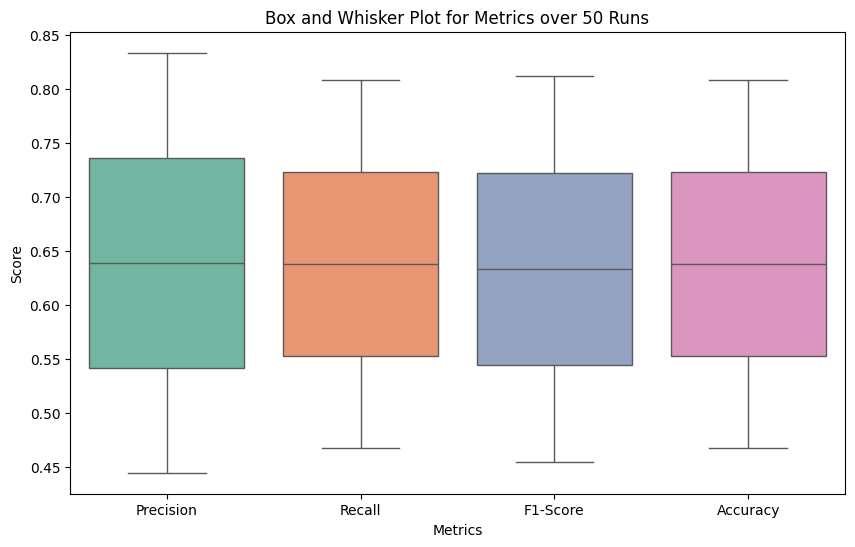

In [26]:


# ساخت DataFrame برای رسم نمودار
data = pd.DataFrame({
    'Metric': ['Precision'] * 2 + ['Recall'] * 2 + ['F1-Score'] * 2 + ['Accuracy'] * 2,
    'Value': precision_scores + recall_scores + f1_scores + accuracy_scores
})

# رسم نمودار Box and Whisker با Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=data, hue='Metric', palette='Set2')
plt.title('Box and Whisker Plot for Metrics over 50 Runs')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()

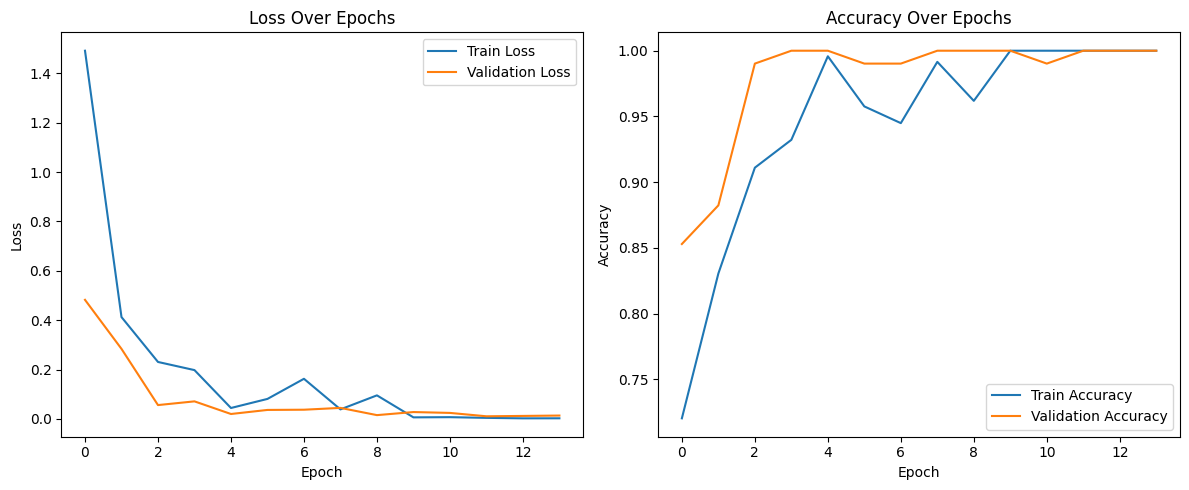

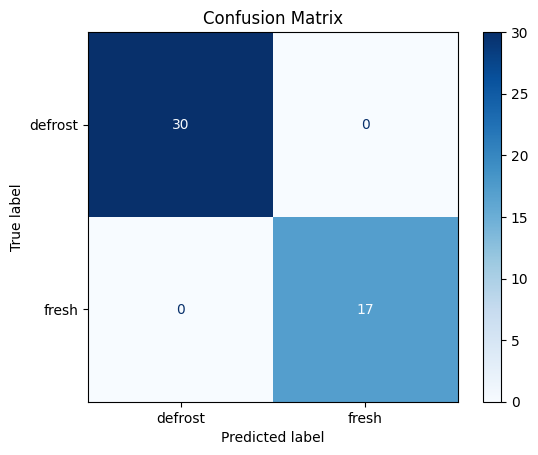

Specificity for class defrost: 1.0000
Specificity for class fresh: 1.0000


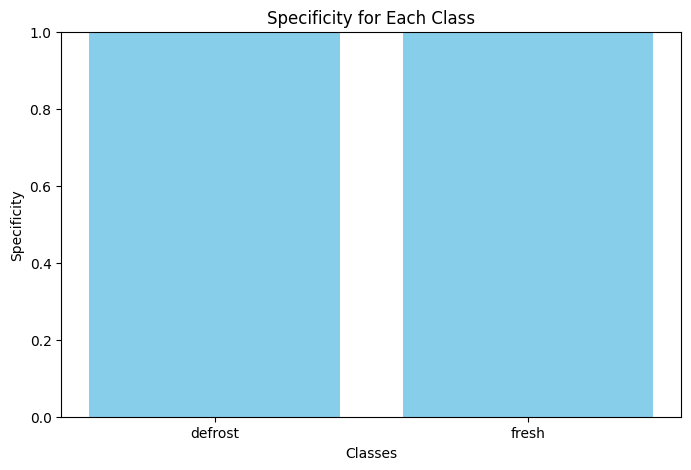

Number of misclassified samples: 0


In [48]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torchvision.transforms as transforms
from torch.nn.functional import softmax

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# رسم نمودار Loss و Accuracy
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # نمودار Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# محاسبه و نمایش Specificity برای هر کلاس
def calculate_specificity(cm, class_names):
    specificities = []
    for i in range(len(class_names)):
        true_negatives = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        false_positives = cm[:, i].sum() - cm[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificities.append(specificity)
    return specificities

# رسم Confusion Matrix و نمایش Specificity
def plot_confusion_matrix(model, dataloaders, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format=".0f")
    plt.title("Confusion Matrix")
    plt.show()

    # محاسبه Specificity
    specificities = calculate_specificity(cm, class_names)
    for i, specificity in enumerate(specificities):
        print(f"Specificity for class {class_names[i]}: {specificity:.4f}")

    # رسم نمودار Specificity
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, specificities, color='skyblue')
    plt.title("Specificity for Each Class")
    plt.xlabel("Classes")
    plt.ylabel("Specificity")
    plt.ylim(0, 1)
    plt.show()

# نمایش نمونه‌های اشتباه پیش‌بینی شده
def plot_misclassified_samples(model, dataloaders, class_names):
    inv_normalize = transforms.Normalize(
        mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5],
        std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
    )

    model.eval()
    misclassified_samples = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_samples.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))

    print(f"Number of misclassified samples: {len(misclassified_samples)}")

    for idx, (image, predicted, true) in enumerate(misclassified_samples[:10]):  # نمایش 10 نمونه اول
        image = inv_normalize(image)  # بازگرداندن تصویر به حالت اصلی
        image = transforms.ToPILImage()(image)

        plt.imshow(image)
        plt.title(f"Predicted: {class_names[predicted]}, True: {class_names[true]}")
        plt.axis('off')
        plt.show()

# اجرای همه نمودارها
def plot_all_results(train_losses, val_losses, train_accuracies, val_accuracies, model, dataloaders, class_names):
    # رسم Loss و Accuracy
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Confusion Matrix و Specificity
    plot_confusion_matrix(model, dataloaders, class_names)

    # Misclassified Samples
    plot_misclassified_samples(model, dataloaders, class_names)

# فراخوانی این تابع پس از آموزش مدل
plot_all_results(
    train_losses=train_losses,  # لیست مقادیر Loss آموزش
    val_losses=val_losses,      # لیست مقادیر Loss اعتبارسنجی
    train_accuracies=train_accuracies,  # لیست دقت آموزش
    val_accuracies=val_accuracies,      # لیست دقت اعتبارسنجی
    model=model,  # مدل آموزش دیده
    dataloaders=dataloaders,  # DataLoaderها
    class_names=class_names  # نام کلاس‌ها
)
